In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances
from src.XAI.torch_probing import train_probes

/tmp/ipykernel_6346/1864037837.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
env_steps = Concept.load_concept_data()
concept = concept_instances['events quantity']
concept.prepare_data(env_steps, max_size=1000)
concept.summary()

Concept: events quantity
binary: False
train: (800, 84, 84, 12) (800,)
test: (200, 84, 84, 12) (200,)


In [4]:
model_path = QNetwork.find_newest_model()
model = QNetwork(frame_stacks=4, model_path=model_path)
print(f"Using model: {model_path}")

Using model: runs/20240128-235322/model_10000000.pt


In [5]:
train_obs_tensor = torch.tensor(concept.train_obs, dtype=torch.float32)
q_values, acts = model(train_obs_tensor, return_acts=True)

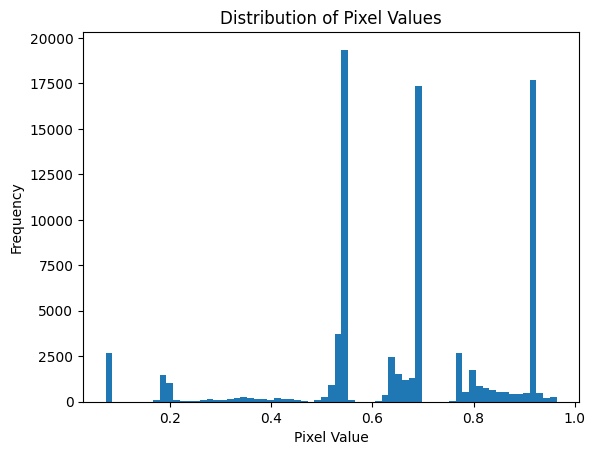

In [6]:
train_obs_scaled = concept.train_obs / 255.0
plt.hist(train_obs_scaled.mean(axis=0).flatten(), bins='auto')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Pixel Values')
plt.show()

     Layer      Mean       Std
0  Layer 0 -2.385943  3.029957
1  Layer 1  0.079939  0.277204
2  Layer 2 -1.040163  0.941263
3  Layer 3  0.013861  0.053541
4  Layer 4 -0.633576  0.498626
5  Layer 5  0.023064  0.059596
6  Layer 6  0.023064  0.059596
7  Layer 7 -1.635530  1.699031
8  Layer 8  0.081479  0.512844


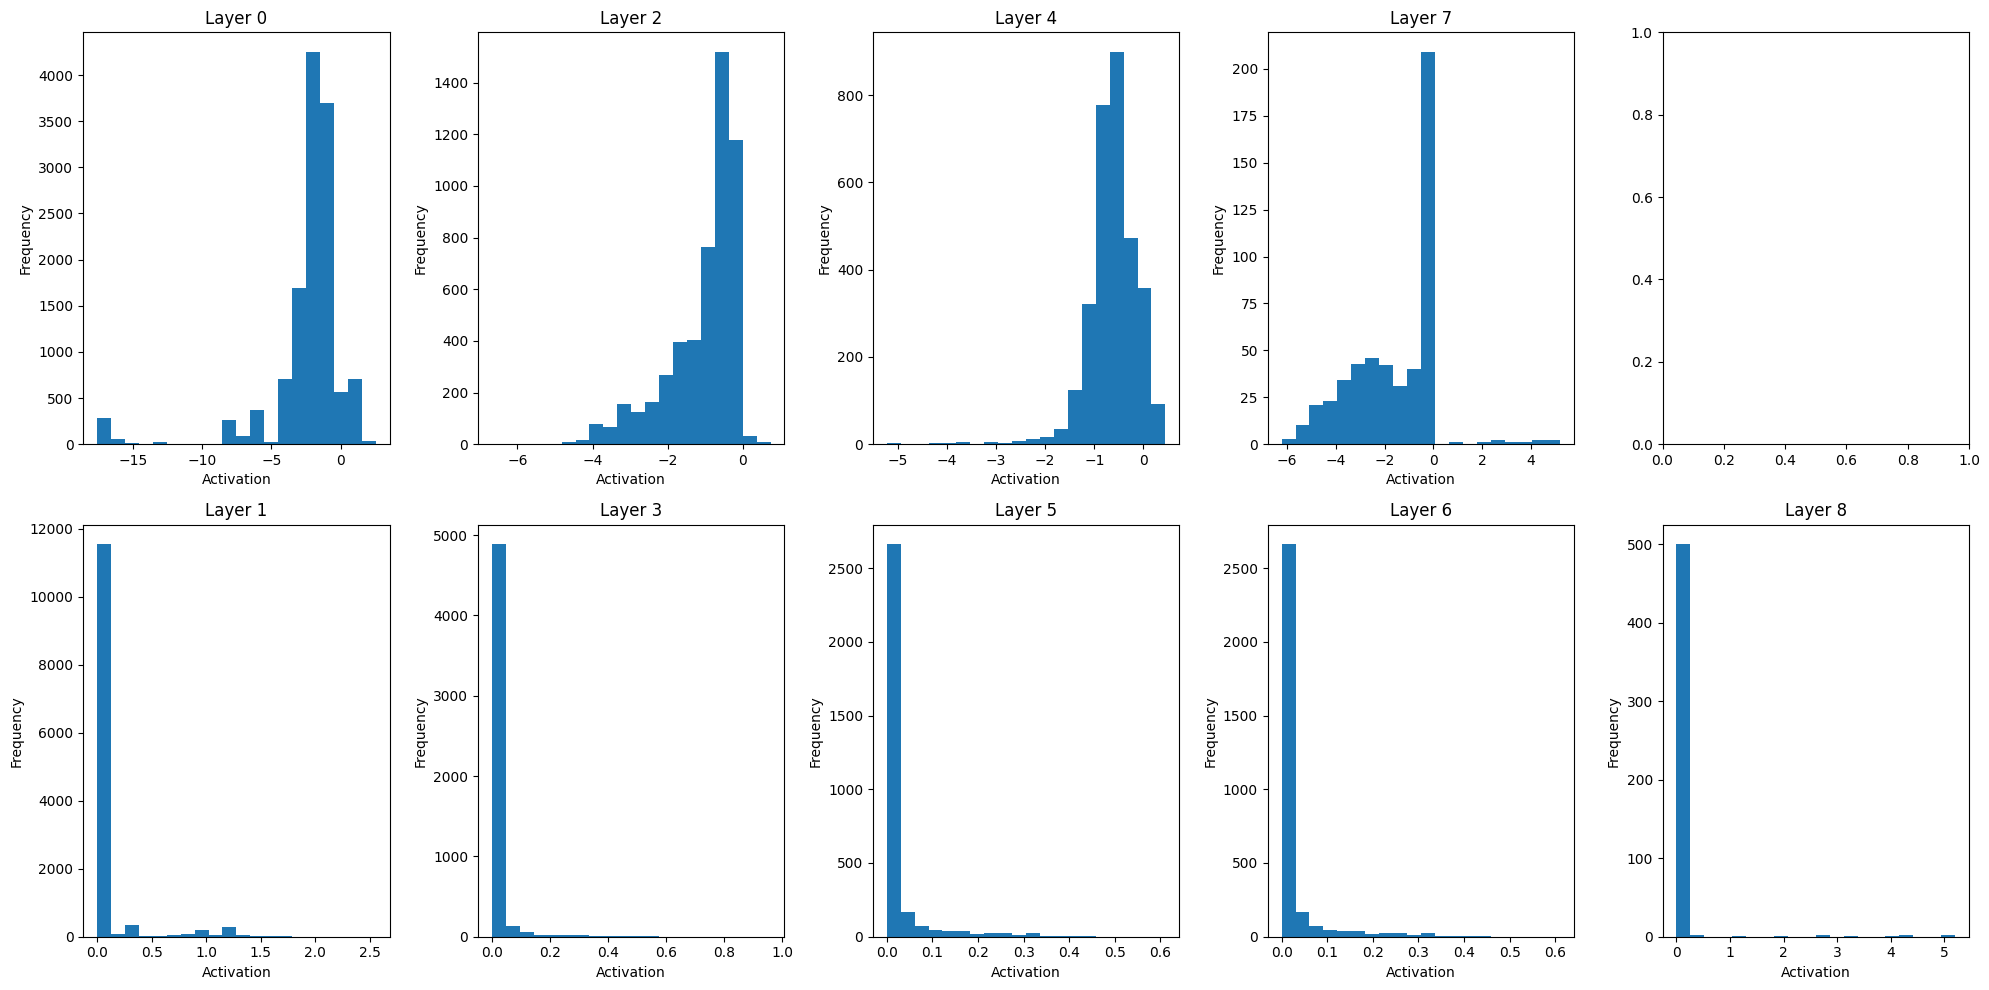

In [7]:
layer_names = []
means = []
stds = []

layers = range(9)
top_row = [0, 2, 4, 7]
bottom_row = [1, 3, 5, 6, 8]
fig, axs = plt.subplots(2, 5, figsize=(8 * 2.5, 10))

def get_subplot_index(layer):
    if layer in [0, 2, 4, 7]:
        return 0, top_row.index(layer)
    else:
        return 1, bottom_row.index(layer)

for layer in layers:
    activations = acts[layer].cpu().numpy().mean(axis=0).flatten()
    mean = activations.mean()
    std = activations.std()

    # Store statistics
    layer_names.append(f'Layer {layer}')
    means.append(mean)
    stds.append(std)

    row, col = get_subplot_index(layer)

    # Plot histogram
    axs[row, col].hist(activations, bins=20)
    axs[row, col].set_xlabel('Activation')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title(f'Layer {layer}')

plt.tight_layout()

stats_df = pd.DataFrame({'Layer': layer_names, 'Mean': means, 'Std': stds})
print(stats_df)

plt.show()